In [1]:
import torch
import sys
import pathlib 
import joblib
import pandas as pd
import numpy as np
import json
import optuna
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from betatcvae import BetaTCVAE, compile_vae, weights
from optimize_utils_tcvae import get_optimizer

script_directory = pathlib.Path("../utils/").resolve()
sys.path.insert(0, str(script_directory))
from data_loader import load_train_test_data

In [2]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_data, test_data, val_data, load_gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True, zero_one_normalize=True, adult_or_ped="all"
)

train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [3]:
# Load the best hyperparameters
study_name = "Beta_TCVAE-Optimization"
storage_name = f"sqlite:///./{study_name}.db"
study = optuna.load_study(study_name=study_name, storage=storage_name)
best_trial = study.best_trial

latent_dim = best_trial.params['latent_dim']
beta = best_trial.params['beta']
learning_rate = best_trial.params['learning_rate']
batch_size = best_trial.params['batch_size']
epochs = best_trial.params['epochs']
optimizer = best_trial.params['optimizer_type']

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size, shuffle=False)

In [4]:
#Initialize the model and optimizer
model = BetaTCVAE(input_dim=train_data.shape[1], latent_dim=latent_dim, beta=beta)
optimizer = get_optimizer(optimizer, model.parameters(), learning_rate)

# Training model
train_loss_history, val_loss_history, test_loss_history = compile_vae(model, train_loader, val_loader, test_loader, optimizer, epochs)

Epoch 1, Train Loss: 405.2185559628615, Val Loss: 111.10080464680989, Test Loss: 110.560545179579
Epoch 2, Train Loss: 57.81410786642957, Val Loss: 63.55764304267036, Test Loss: 64.4802000257704
Epoch 3, Train Loss: 44.39565283931903, Val Loss: 56.721643659803604, Test Loss: 57.097937689887154
Epoch 4, Train Loss: 46.23422068126166, Val Loss: 52.088111029730904, Test Loss: 52.399159325493706
Epoch 5, Train Loss: 48.21101411278568, Val Loss: 48.125374264187286, Test Loss: 48.946844312879776
Epoch 6, Train Loss: 46.633657973559934, Val Loss: 45.61483891805013, Test Loss: 46.557840983072914
Epoch 7, Train Loss: 44.71093531366604, Val Loss: 44.254417419433594, Test Loss: 45.026351081000435
Epoch 8, Train Loss: 43.29402529588386, Val Loss: 43.31857596503364, Test Loss: 44.411139170328774
Epoch 9, Train Loss: 42.48002027824744, Val Loss: 42.13854429456923, Test Loss: 42.91981972588433
Epoch 10, Train Loss: 41.476102458896925, Val Loss: 41.4091673956977, Test Loss: 41.96655485365126
Epoch 11,

In [5]:
# Save the model
model_path = pathlib.Path("results/best_tc_vae_model.pth")
torch.save(model.state_dict(), model_path)

In [6]:
# Save training history
history = {
    'loss' : train_loss_history,
    'val_loss': val_loss_history,
    'test_loss': test_loss_history
}

history_path = pathlib.Path("results/tc_training_history.json")
with open(history_path, 'w') as f:
    json.dump(history, f)

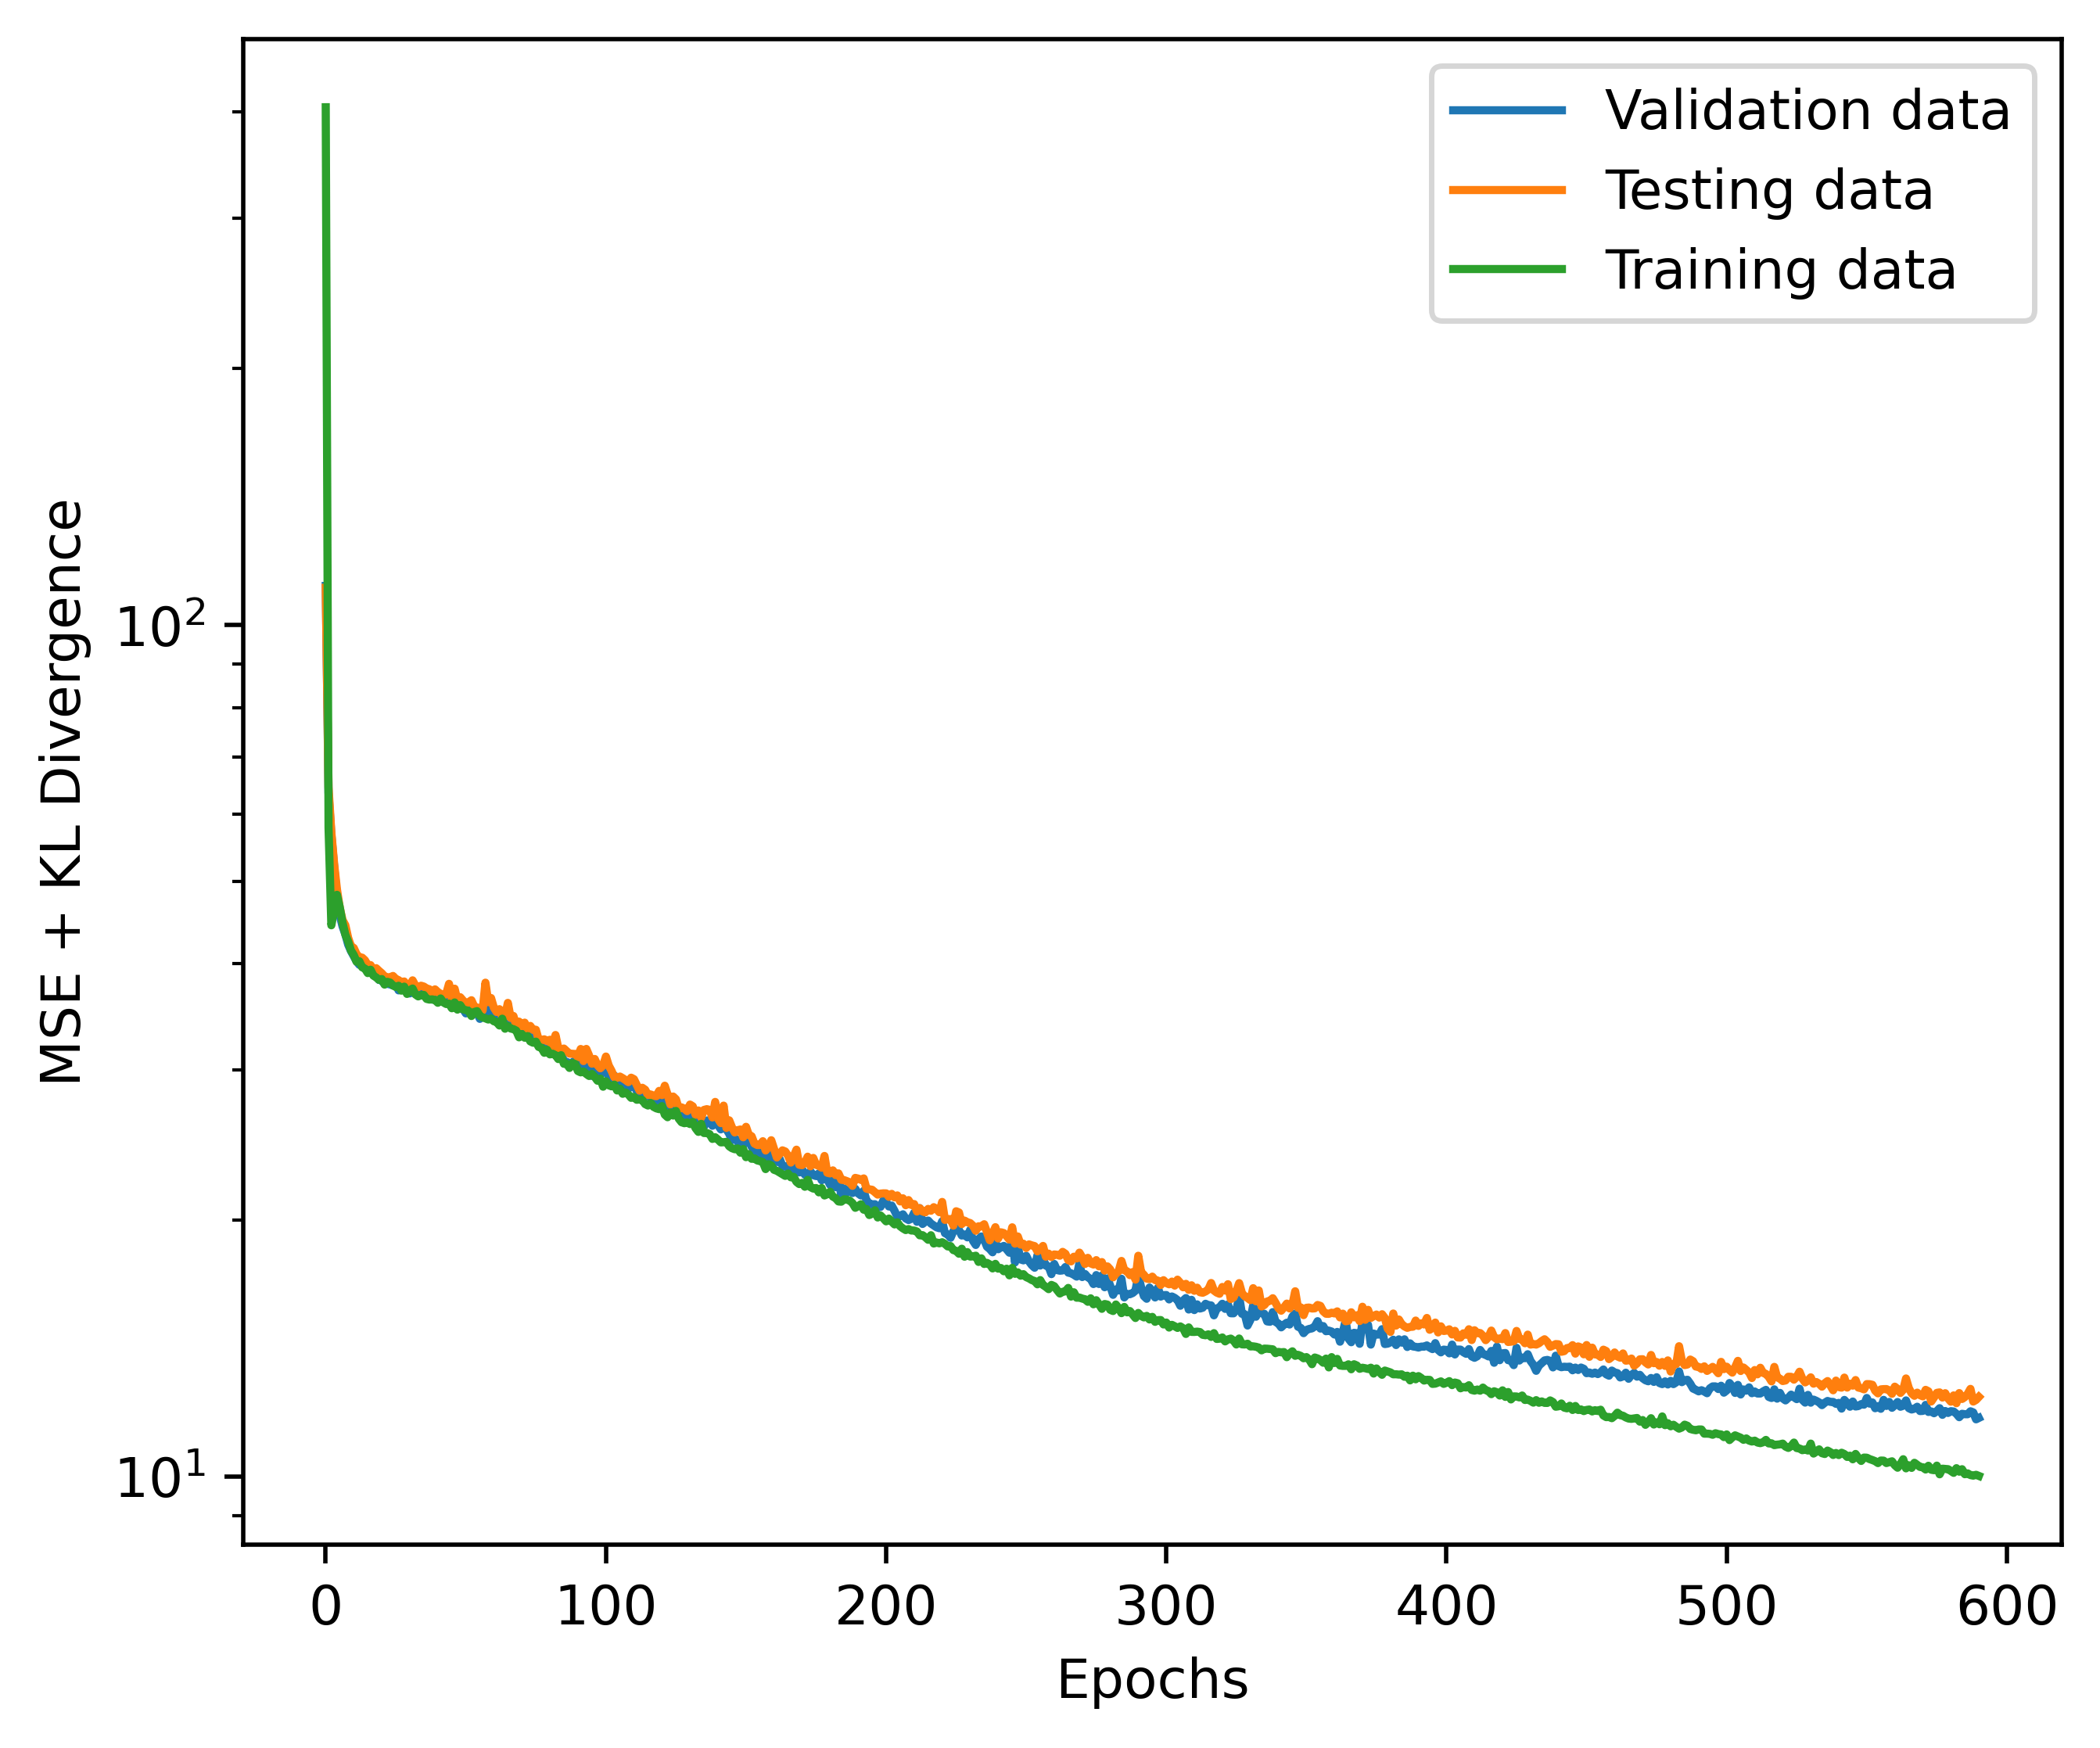

In [7]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

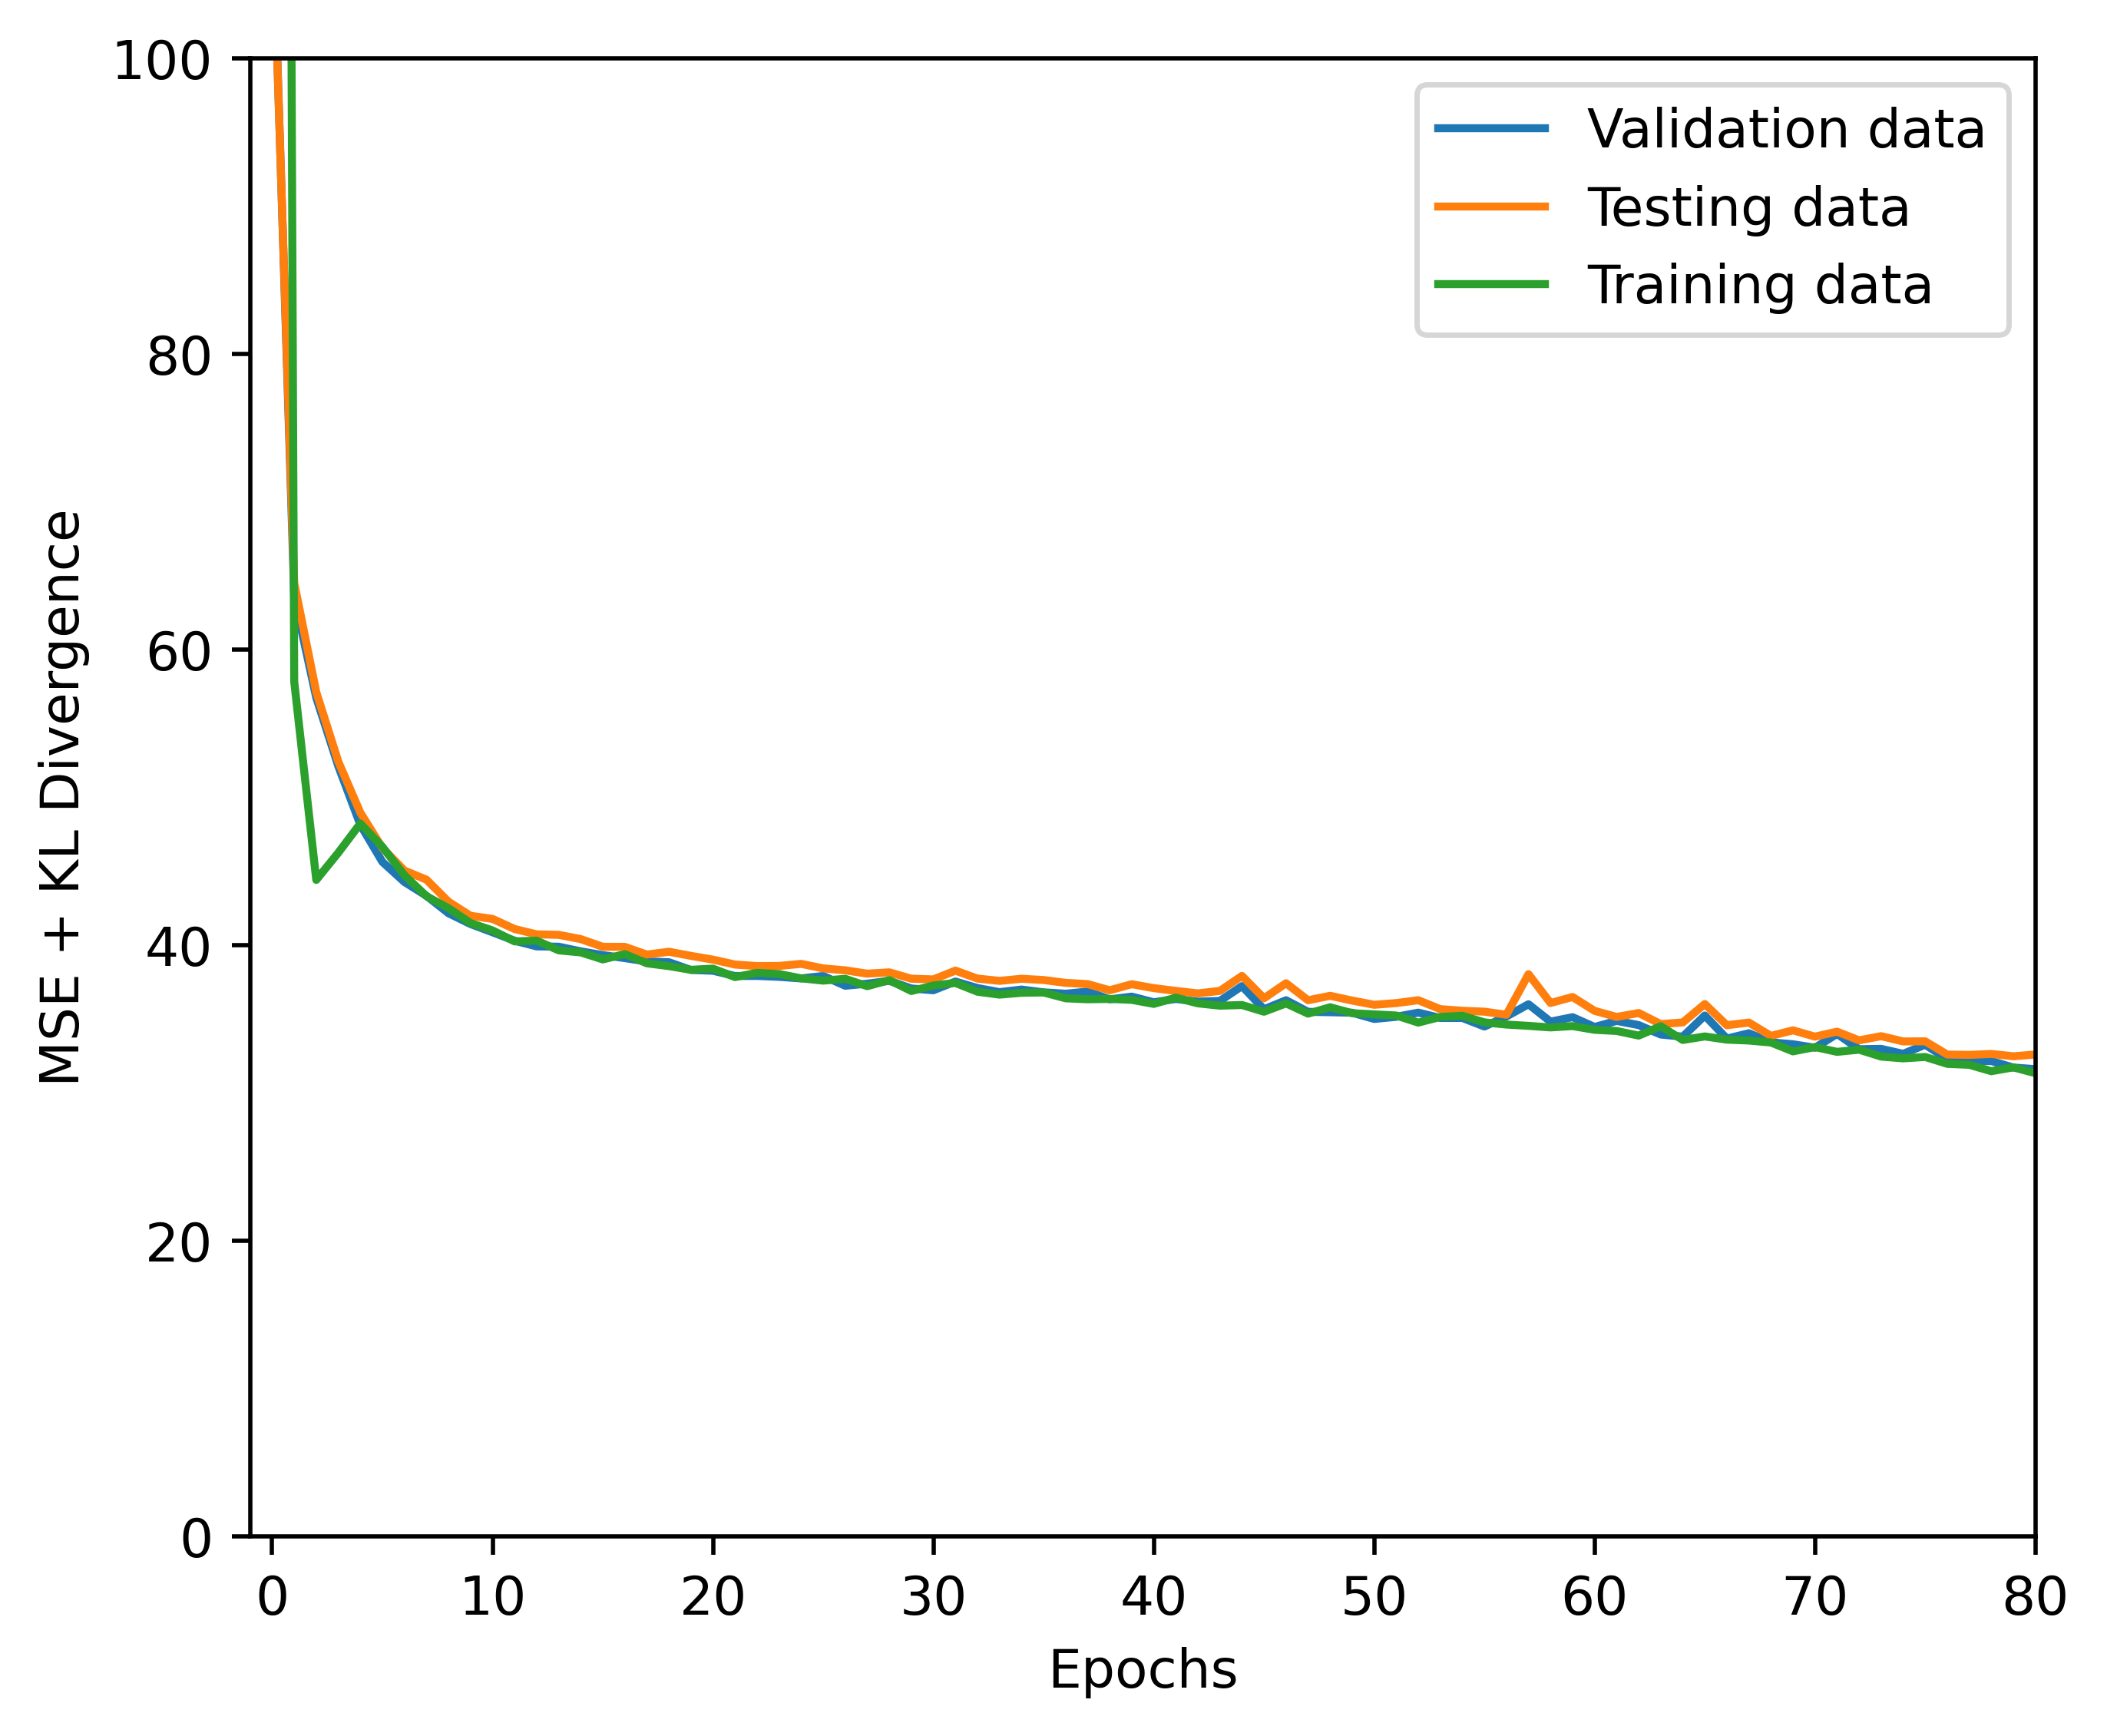

In [8]:
save_path = pathlib.Path("../1.data-exploration/figures/tc_training_curve_elbow.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.xlim(-1,80)
plt.ylim(0,100)
plt.plot(val_loss_history, label="Validation data")
plt.plot(test_loss_history, label="Testing data")
plt.plot(train_loss_history, label="Training data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epochs")
plt.legend()
plt.savefig(save_path)
plt.show()

In [9]:
# Load data
data_directory = pathlib.Path("../0.data-download/data").resolve()
train_df = load_train_test_data(
    data_directory, train_or_test="train", drop_columns=False
)

train_df[["AgeCategory", "Sex"]] = train_df.age_and_sex.str.split(
    pat="_", expand=True
)

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_parquet(
    "../0.data-download/data/CRISPR_gene_dictionary.parquet"
)
gene_list_passed_qc = gene_dict_df.loc[
    gene_dict_df["qc_pass"], "dependency_column"
].tolist()

#Extract and process weights 
path = "./results/weight_matrix_gsea_tc.parquet"
train_data = train_df.filter(gene_list_passed_qc, axis=1)
final_gene_weights_df = weights(model, train_data, path)